<a href="https://www.kaggle.com/code/piotrpowroznik/road-signs-categories-cnn-classification?scriptVersionId=259956801" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Road Signs Categories CNN Classification

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers


In [2]:
test_path = "/kaggle/input/russian-road-signs-categories-dataset/test"
train_path = "/kaggle/input/russian-road-signs-categories-dataset/train"


## Load Data

In [3]:
train_datagen = ImageDataGenerator(
    validation_split=0.15,
    rescale=1./255,
    rotation_range=30,
    shear_range=0.2,
    zoom_range=0.2
)

train_ds = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=128,
    class_mode='categorical',
    subset="training" 
)

validation_ds = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=128,
    class_mode='categorical',
    subset="validation" 
)


Found 47600 images belonging to 8 classes.
Found 8400 images belonging to 8 classes.


In [4]:
# Check dataset sizes
print(f"Training images: {train_ds.samples}")
print(f"Validation images: {validation_ds.samples}")


Training images: 47600
Validation images: 8400


In [5]:
class_names = list(train_ds.class_indices.keys())
print("Categories:", class_names)

Categories: ['1', '2', '3', '4', '5', '6', '7', '8']


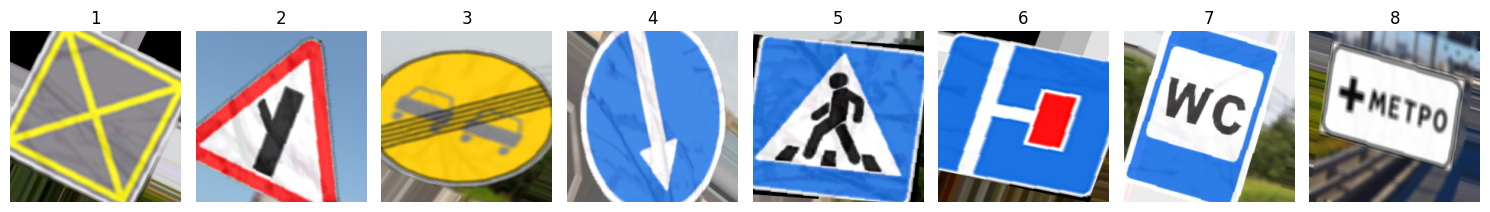

In [6]:
category_images = {}

# Loop through batches until we get one image per category
for images, labels in train_ds:
    for img, label in zip(images, labels):
        category_index = np.argmax(label)  # Convert one-hot to category index
        category_name = class_names[category_index]

        if category_name not in category_images:  # Store first occurrence
            category_images[category_name] = img

    if len(category_images) == len(class_names):  # Stop when we have all categories
        break

fig, axes = plt.subplots(1, len(class_names), figsize=(15, 5))
for i, category in enumerate(class_names):
    ax = axes[i]
    ax.imshow(category_images[category])
    ax.axis("off")
    ax.set_title(category)

plt.tight_layout()
plt.show()


## Define Model

In [7]:
model = keras.Sequential([
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    layers.Dropout(0.2),
    layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),

    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.Dropout(0.2),
    layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    
    layers.Conv2D(filters=64, kernel_size=(5, 5), activation='relu', padding='same'),
    layers.Dropout(0.3),
    layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    
    layers.Conv2D(filters=128, kernel_size=(5, 5), activation='relu'),
    layers.Dropout(0.3),
    layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    
    layers.Flatten(),

    layers.Dense(64, activation='relu'),
    layers.Dropout(0.4),

    layers.Dense(32, activation='relu'),

    layers.Dense(8, activation='softmax')
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 111, 111, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 111, 111, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 55, 55, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 55, 55, 64)          │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 55, 55, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 27, 27, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 23, 23, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 23, 23, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 11, 11, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 15488)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         991,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │             264 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,320,424 (5.04 MB)

 Trainable params: 1,320,424 (5.04 MB)

 Non-trainable params: 0 (0.00 B)

## Compile Model

In [9]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


## Training Support Callbacks

In [10]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True
)
 
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=0.0001
)


## Train Model

In [11]:
history = model.fit(
    train_ds,
    epochs=10,
    batch_size=128,
    validation_data=validation_ds,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


372/372 ━━━━━━━━━━━━━━━━━━━━ 911s 2s/step - accuracy: 0.5574 - loss: 1.1096 - val_accuracy: 0.8855 - val_loss: 0.5697 - learning_rate: 0.0010
Epoch 2/10
372/372 ━━━━━━━━━━━━━━━━━━━━ 753s 2s/step - accuracy: 0.8762 - loss: 0.3364 - val_accuracy: 0.9495 - val_loss: 0.2908 - learning_rate: 0.0010
Epoch 3/10
372/372 ━━━━━━━━━━━━━━━━━━━━ 752s 2s/step - accuracy: 0.9356 - loss: 0.1833 - val_accuracy: 0.9733 - val_loss: 0.1626 - learning_rate: 0.0010
Epoch 4/10
372/372 ━━━━━━━━━━━━━━━━━━━━ 751s 2s/step - accuracy: 0.9542 - loss: 0.1302 - val_accuracy: 0.9737 - val_loss: 0.1714 - learning_rate: 0.0010
Epoch 5/10
372/372 ━━━━━━━━━━━━━━━━━━━━ 755s 2s/step - accuracy: 0.9675 - loss: 0.0913 - val_accuracy: 0.9887 - val_loss: 0.0836 - learning_rate: 0.0010
Epoch 6/10
372/372 ━━━━━━━━━━━━━━━━━━━━ 760s 2s/step - accuracy: 0.9741 - loss: 0.0751 - val_accuracy: 0.9875 - val_loss: 0.0937 - learning_rate: 0.0010
Epoch 7/10
372/372 ━━━━━━━━━━━━━━━━━━━━ 756s 2s/step - accuracy: 0.9781 - loss: 0.0644 - val_

In [12]:
model.save("road_signs_classifier_model.h5")

## Learning Curves

<Axes: >

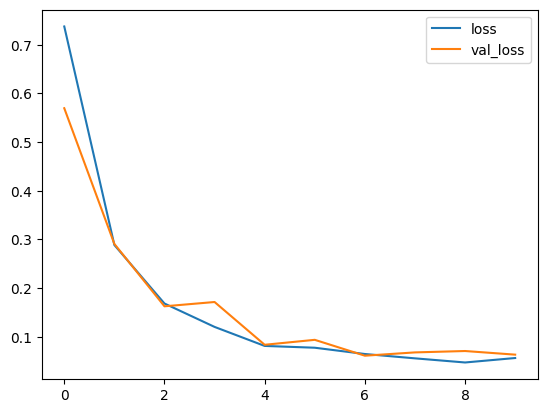

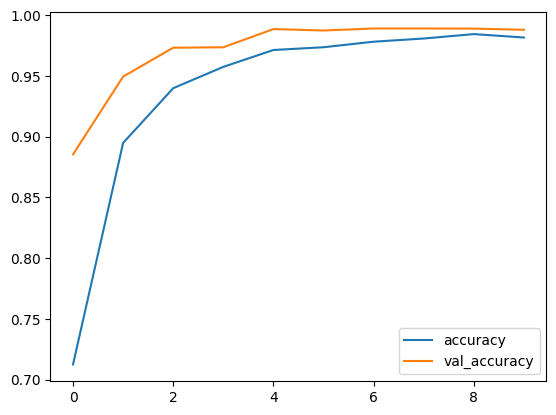

In [13]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()


## Example Classification

In [14]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_ds = test_datagen.flow_from_directory(
    "/kaggle/input/russian-road-signs-categories-dataset/test",
    target_size=(224, 224),
    batch_size=15,
    class_mode="categorical",
    shuffle=True
)

Found 24000 images belonging to 8 classes.


In [15]:
test_images, test_labels = next(test_ds)

predictions = model.predict(test_images)

predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)

class_names = list(test_ds.class_indices.keys())


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


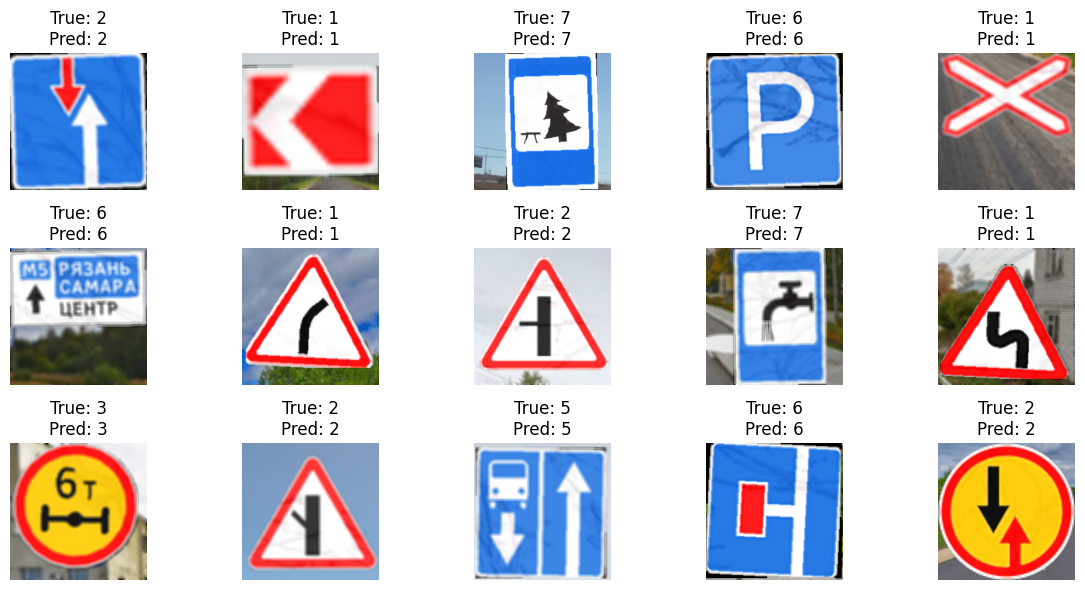

In [16]:
fig, axes = plt.subplots(3, 5, figsize=(12, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(test_images[i], cmap="gray")
    ax.set_title(f"True: {class_names[true_labels[i]]}\nPred: {class_names[predicted_labels[i]]}")
    ax.axis("off")

plt.tight_layout()
plt.show()
